In [99]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# 資料基本概況檢查

In [100]:
df_origin=pd.read_csv("../data/aug_train.csv")
df_origin.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [101]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [102]:
df_origin.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [103]:
df_origin.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [104]:
df_origin.describe(include=['object', 'category'])

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


# 缺失值處理
<p></p>
<p></p>
<p></p>

# 用圖探索( 1.目標變數是否平衡 2. 類別變數分布狀況 3. 數值變數分布狀況 4.類別 vs 目標變數的對比 ) 
<p>1. 目標變數是否平衡 → 後續模型是否要平衡class_weight='balanced' & train_test_split 加入 stratify=y </p>
<p>2. 類別變數分布狀況 → 大多集中在某一類別，對預測沒幫助可刪除、太少的類別則可合併or drop</p>
<p>3. 數值變數分布狀況 → 刪除極端值、觀察常態性</p>
<p>4. 類別 vs 目標變數的對比 → 找出重要特徵，以利特徵篩選  </p>

### 1. 目標變數是否平衡


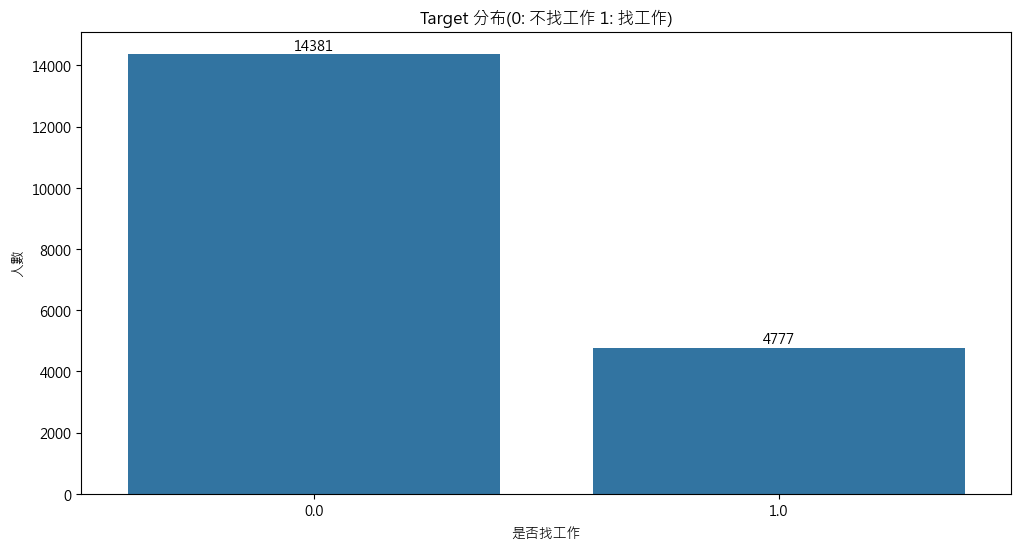

In [105]:
plt.figure(figsize=(12,6))
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False
ax=sns.countplot(x=df_origin["target"],data=df_origin)
plt.title("Target 分布(0: 不找工作 1: 找工作)")
plt.xlabel("是否找工作")
plt.ylabel("人數")

# bar 上顯示數值
for container in ax.containers:
    ax.bar_label(container,label_type='edge')



plt.show()

In [106]:
# check目標變項比例是否平衡
df_origin['target'].value_counts(normalize=True)

target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64

### 2. 類別變數分布狀況
<p>1. 類別分布是否偏斜？ →類別比例極高（>70%）需要處理</p>
<p>2. 類別數量是否過多？ → >20類，捨棄or合併</p>
<p>3. 類別數量非常少，且出現頻率極低的類別 → 捨棄or合併</p>
<p>4. 缺失值（NaN）比例 → 比例高，刪除or特殊方式補值；比例低，補值</p>
<p>5. 是否有順序性 →  Ordinal Encoding</p>
<p>6. 後續特徵的選擇 → 不明顯的考慮刪除</p>

In [107]:
categorical_cols = [
    'city', 'gender', 'relevent_experience', 'enrolled_university',
    'education_level', 'major_discipline', 'experience',
    'company_size', 'company_type', 'last_new_job'
]

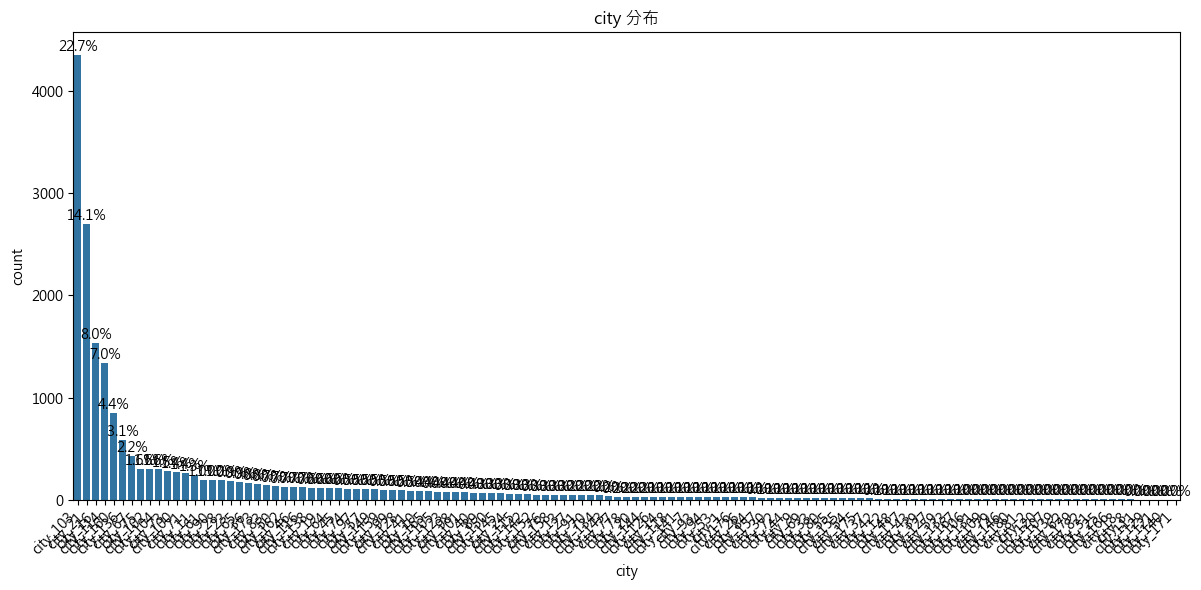

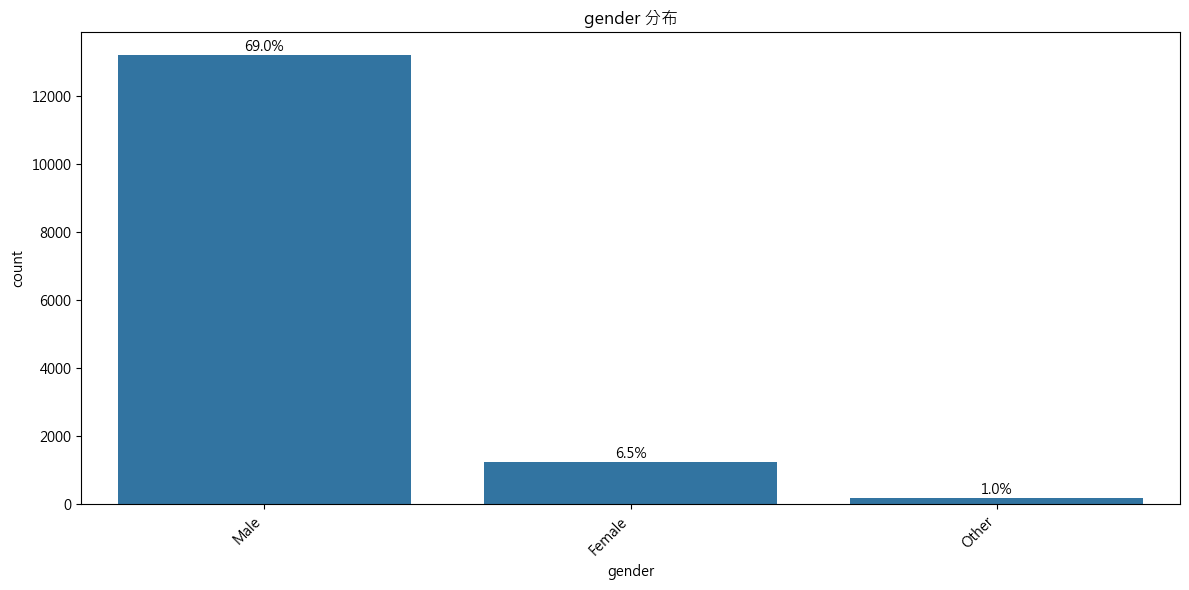

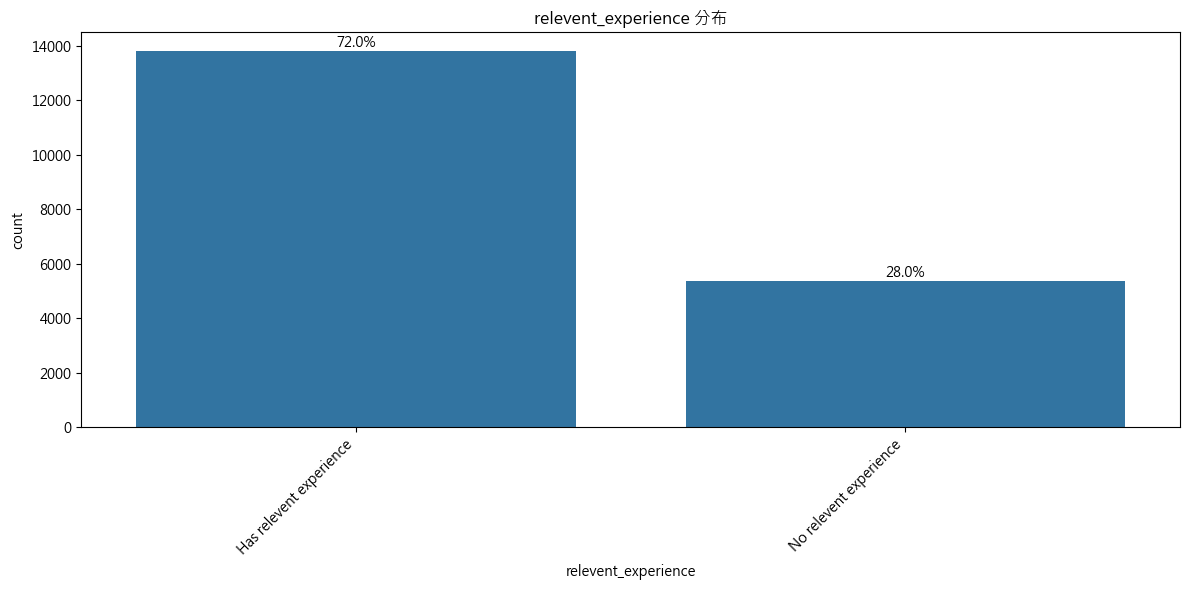

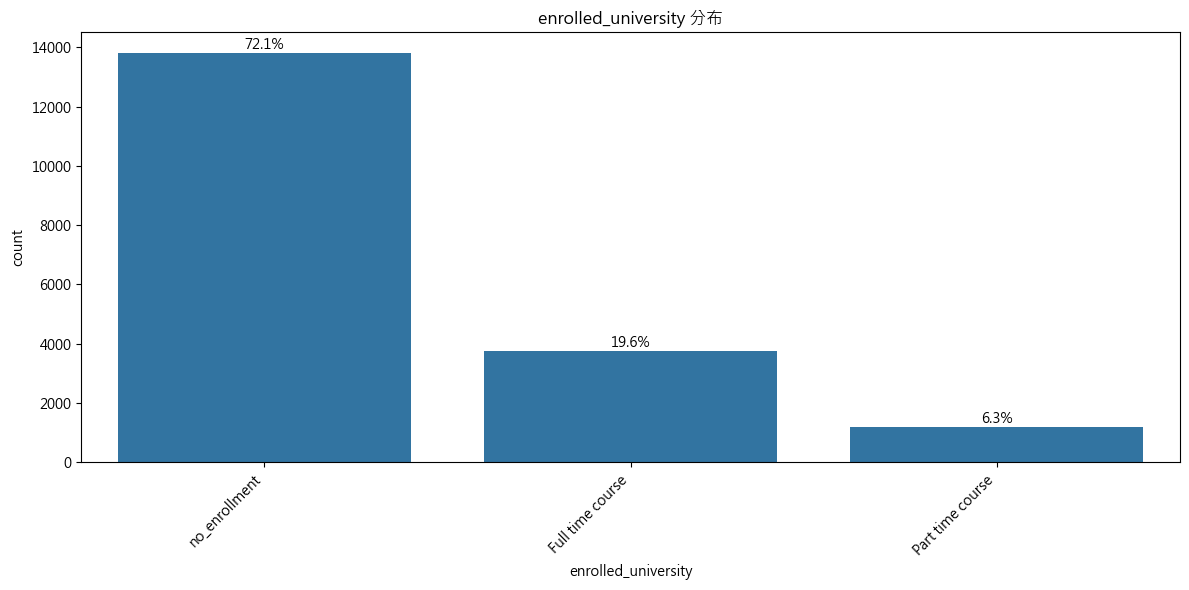

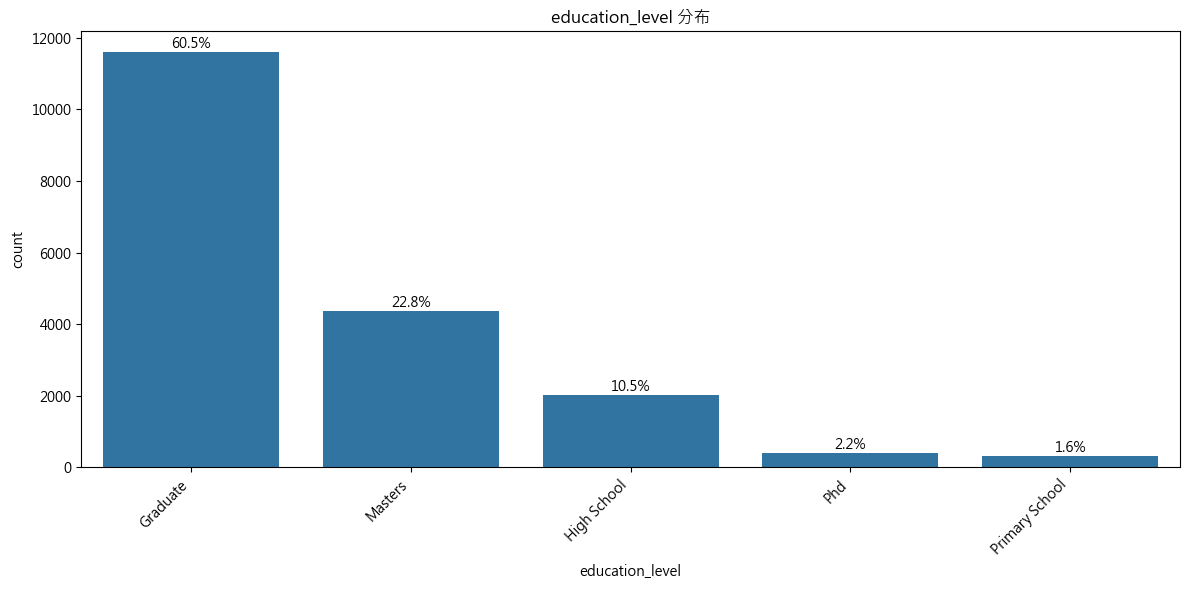

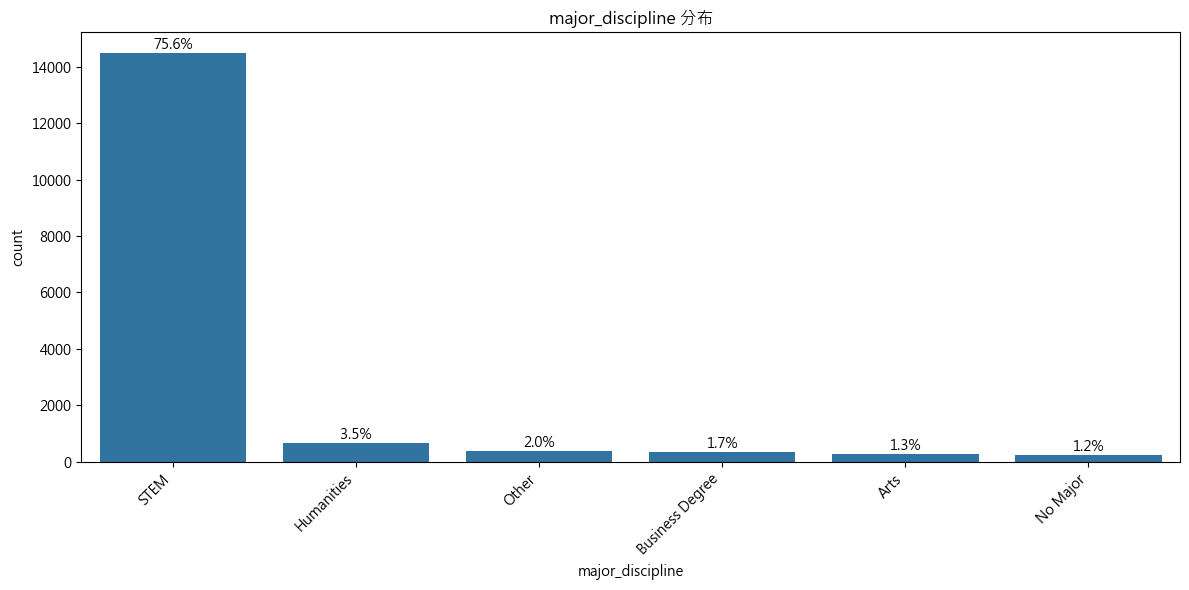

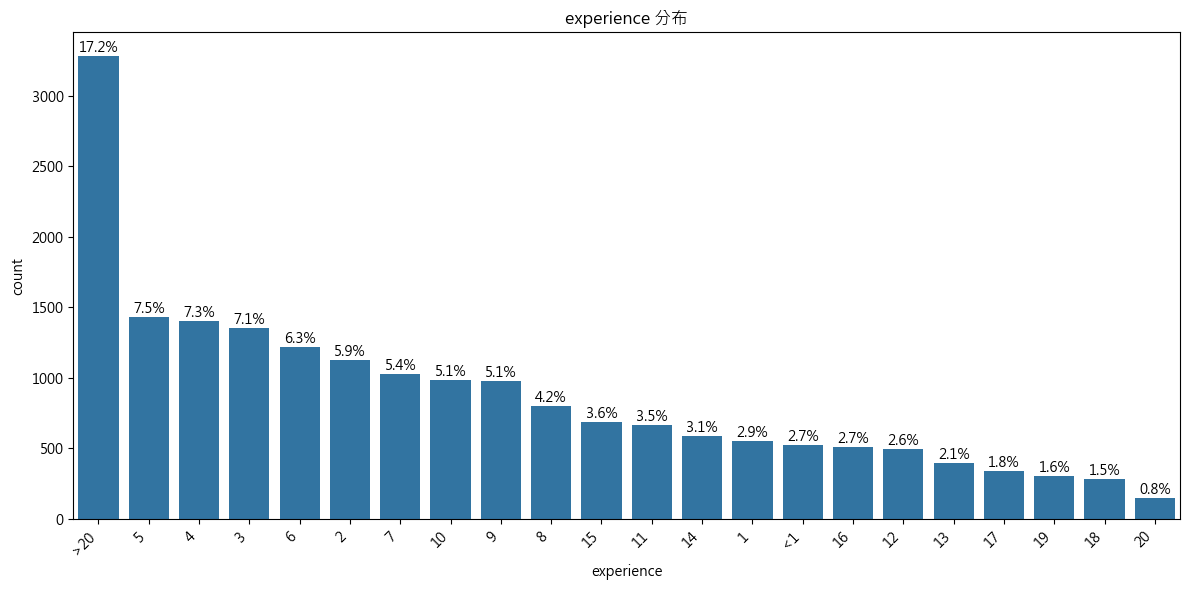

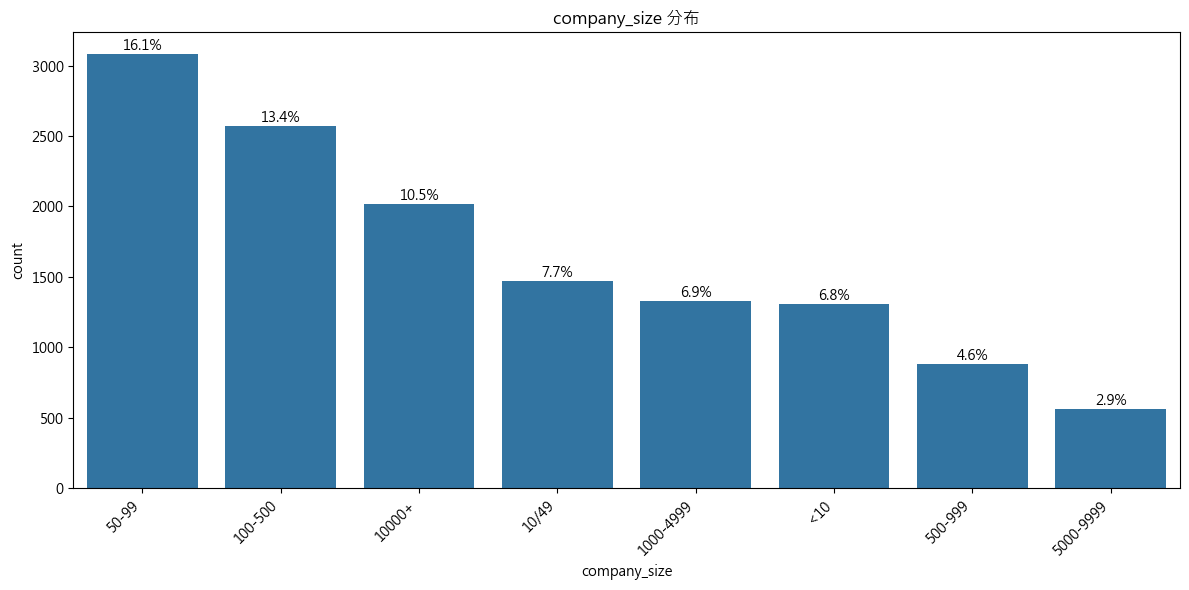

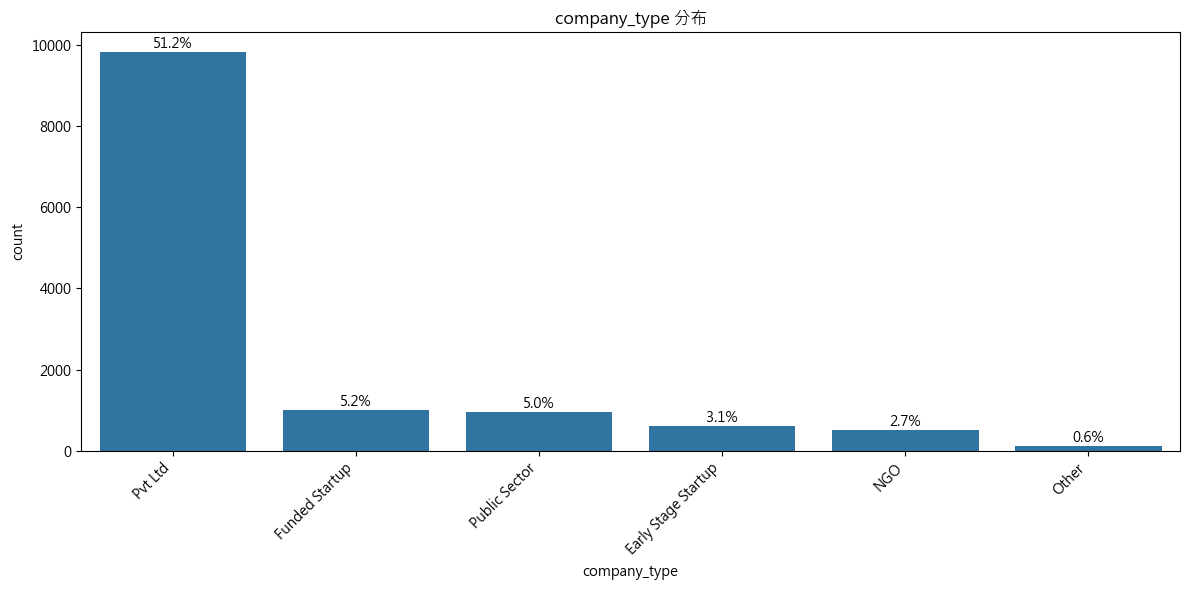

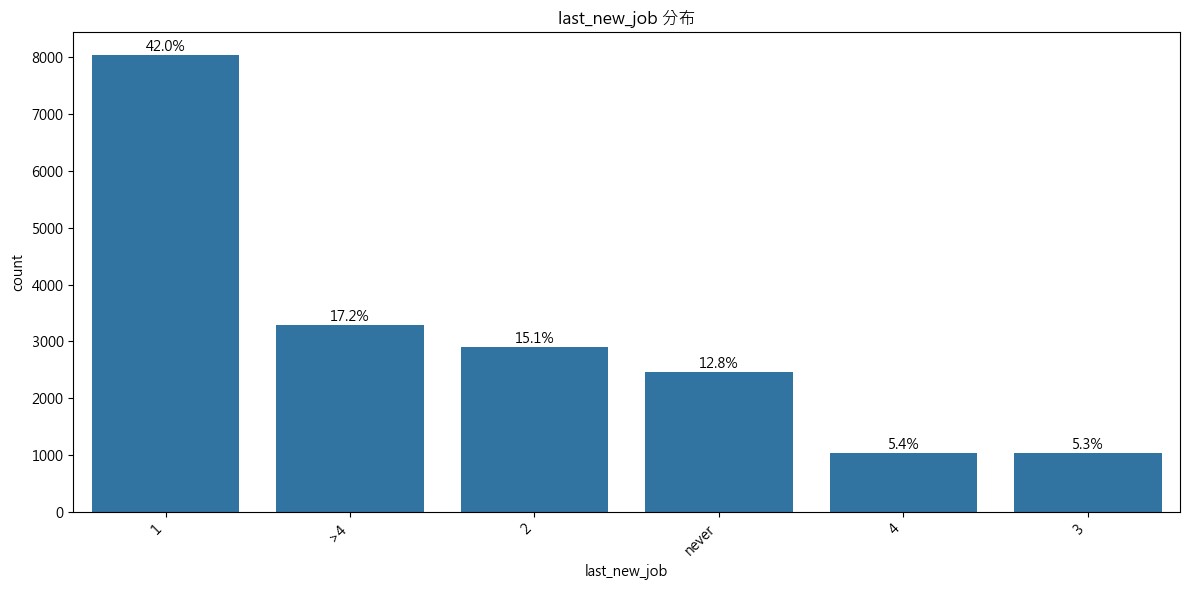

In [108]:
for col in categorical_cols:
    plt.figure(figsize=(12,6))
    order= df_origin[col].value_counts().index #排序
    ax=sns.countplot(data=df_origin,x=col,order=order)
    plt.title(f'{col} 分布')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # bar 上標示數值
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height / len(df_origin) * 100:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10)
    plt.show()